Définition des folder

In [1]:
import os

INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/sample_images'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

Chargement des coupes pour un patient. Chaque dossier correspond aux différentes coupe pour un patient donné

In [2]:
import dicom
import pylab
import os
import numpy as np
import scipy.ndimage


def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices




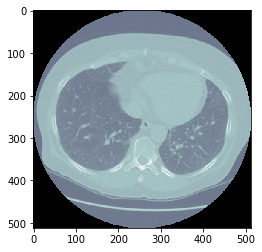

In [3]:
first_patient_path = os.path.join(INPUT_FOLDER,patients[0])
first_patient = load_scan(first_patient_path)
total_images = os.listdir(first_patient_path)


ds=dicom.read_file(os.path.join(first_patient_path,total_images[50]))
pylab.imshow(ds.pixel_array, cmap=pylab.cm.bone)
pylab.show()

Pour l'instant, notre seul intérêt ce sont les images. Pour un patient donné (ici le premier), on va donc mettre dans un tenseur de taille NOMBRE_SLICE X 512 X 512, toutes les slices

In [4]:
slices = first_patient
image = np.stack([s.pixel_array for s in slices])
print(image.shape)

(128, 512, 512)


### Gestion des Hounsfield Units

Regardons un peu l'allure des valeurs numériques stockées pour un patient

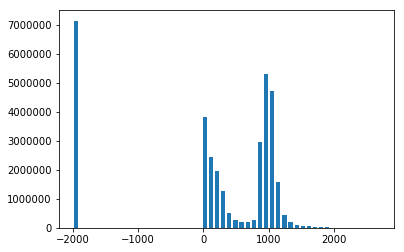

In [5]:
import matplotlib.pyplot as plt

flatten = image.flatten()
hist, bins = np.histogram(flatten, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

On peut alors constater deux choses :

- Les valeurs ne sont pas normées entre 0 et 1, ni entre 0 et 255, mais ont l'air d'aller de 0 à 2xxx
- Beaucoup de valeurs sont à - 2000, étrange.

Première démarche : où sont localisées ces valeurs à -2 000 ?

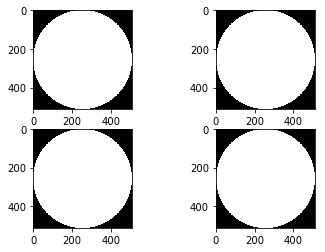

In [7]:
#Le but ici va être de visualiser les -2 000, on va avoir une démarche simple : 
#on crée une copie de notre tenseur d'image, on met un 0 là où y'a des -2000, un 1 sinon
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nrows, ncols = 512,512

#bool_image = image
#bool_image[bool_image == -2000] = 0
#bool_image[bool_image > -2000] = 1


bool_image = (image==-2000)
bool_image = (bool_image + 1 - 1)

bool_image_1 = bool_image[0,:,:]
bool_image_2 = bool_image[24,:,:]
bool_image_3 = bool_image[49,:,:]
bool_image_4 = bool_image[124,:,:]


plt.subplot(221)
plt.imshow(bool_image_1,cmap=cm.Greys)
plt.subplot(222)
plt.imshow(bool_image_2,cmap=cm.Greys)
plt.subplot(223)
plt.imshow(bool_image_3,cmap=cm.Greys)
plt.subplot(224)
plt.imshow(bool_image_4,cmap=cm.Greys)



On le voit, elles sont à l'extérieur du cylindre dans lequel est effectuée la CT. 


Nos données sont en Pixel Data. Ce n'est pas l'unité canonique de la CT, celle-ci étant plutôt __HounsfieldUnit (HU)__ . Sur _wikipedia_, il est indiqué que ces valeurs vont entre -1 000 et 3 000, ce qui ne correspond pas à ce que nous avons ici. Cependant, dans les metadata ce trouvent les arguments __Rescale Intercept__ et __Rescale Slope__

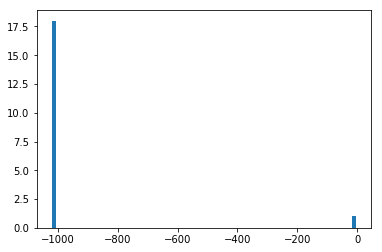

In [8]:
i = 0
Intercept_total = []
patients.sort()
for i in range(len(patients)):
    patient_path = os.path.join(INPUT_FOLDER,patients[i])
    patient = load_scan(patient_path)
    Intercept_total.append(patient[i].RescaleIntercept)

hist, bins = np.histogram(Intercept_total, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()   

A part un cas distinct, le rescale factor vaut -1024. A priori, les valeurs qui correspondent à -2000 sont en fait de l'air, qui à un HU de -1000 après recalibration, en est alors déduit l'opération de transformation suivante :

In [10]:
def PixelData_to_HU(slices):
    #Stack de nos slices dans une tenseur 3D
    image = np.stack([s.pixel_array for s in slices])
    #J ai eu des problmes avec des depassages d'entier
    image = image.astype(np.int16)


    # Les pixels "aberrant (- 2000) sont associés à l'air, qui vaut -1000HU, le rescale valant en général -1024 on fait :
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 24
    
    # Convertion en HU
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        image[slice_number] = slope * image[slice_number].astype(np.int16)
        image[slice_number] = image[slice_number].astype(np.int16) 
        image[slice_number] += np.int16(intercept)
            
    
    return np.array(image)

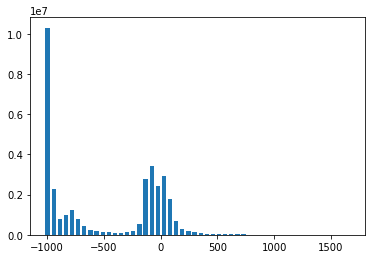

In [11]:
image = PixelData_to_HU(first_patient)


flatten = image.flatten()
hist, bins = np.histogram(flatten, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

__Ainsi, on a pu transformer nos données en unité HU, en s'occupant du cas sortant du cylindre du scanner__

### Resampling

Le nombre de slices par patients est différent, ce qui d'une part va nous poser un problème quand on construira notre CNN, et d'autre part va impacter la qualité de notre prédiction dans la mesure où la distance entre slices varie d'un scan à l'autre. Ainsi, il va être primordiale de Re-Sample nos données, pour homogénéiser la distance entre scan. Ensuite, on ajoutera un padding pour avoir des dimensions équivalentes pour nos input data

In [12]:
L = len(patients)
for i in range(L):
   print(len(os.listdir(os.path.join(INPUT_FOLDER,patients[i]))))

128
133
110
203
196
280
123
164
244
136
180
221
147
435
183
126
177
171
113


In [13]:
def resample(input_image, scan, new_spacing=[1,1,1]):
    
    #L espacement tel qu il est donne
    prior_spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float16)
    #Le facteur de dilatation pour avoir notre nouvel espacement
    resize_factor = prior_spacing / new_spacing
    #Nouvel dimension de l image totale (cad toutes les slices)
    new_real_shape = input_image.shape * resize_factor
    #Mieux avec quelque chose d'entier
    new_shape = np.round(new_real_shape)
    
    real_resize_factor = new_shape / input_image.shape
    new_spacing = prior_spacing / real_resize_factor    
    #La fonction qui gere tout : scipy.ndimage
    output_image = scipy.ndimage.interpolation.zoom(input_image, real_resize_factor, mode='nearest')
    return output_image, new_spacing

In [14]:
first_patient_path = os.path.join(INPUT_FOLDER,patients[1])
first_patient = load_scan(first_patient_path)
image = PixelData_to_HU(first_patient)
pix_resampled, spacing = resample(image,first_patient)

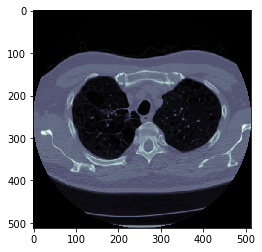

In [15]:
i = 100
plt.imshow(image[i],cmap=plt.cm.bone)

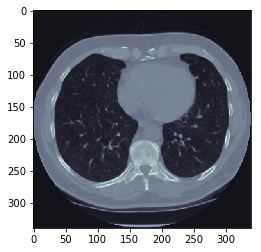

In [16]:
plt.imshow(pix_resampled[i],cmap=plt.cm.bone)

In [17]:
image = pix_resampled

### Segmentation du poumon


Le but ici est de savoir, selon les nodules, s'il y a un cancer ou non. De ce fait, toutes les composantes du scan ne sont pas utiles pour la labellisation, et segmenter les poumons permettera d'alleger grandement le nombre de données transmises au réseau de neuronnes


Tout d'abord, utilisons juste un seuil pour essayer de détecter les poumons, wikipedia nous dit que les poumons sont détectés entre -700 et -600 HU. On prend -500 pour être large

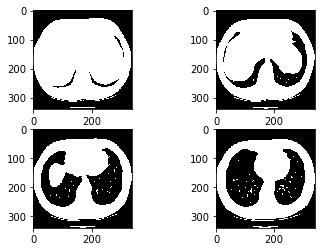

In [18]:
first_patient_path = os.path.join(INPUT_FOLDER,patients[1])
first_patient = load_scan(first_patient_path)
total_images = os.listdir(first_patient_path)

binaries = image < -500


"""Plot"""
plt.subplot(221)
plt.imshow(binaries[25],cmap=cm.Greys)
plt.subplot(222)
plt.imshow(binaries[50],cmap=cm.Greys)
plt.subplot(223)
plt.imshow(binaries[75],cmap=cm.Greys)
plt.subplot(224)
plt.imshow(binaries[100],cmap=cm.Greys)

In [19]:
from skimage.segmentation import clear_border
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing



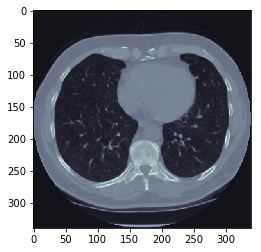

In [20]:
plt.imshow(image[i],cmap=plt.cm.bone)

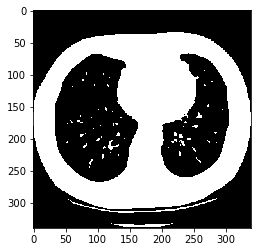

In [21]:
plt.imshow(1-binaries[i],cmap=plt.cm.bone)

En première approche, le résultat est bon. Toutefois, petit gêne sur la ligne en bas, et il va falloir récupérer toute la zone intérieure aux poumons

Tout d'abord, on isole les poumons grâce à "clear_border" de la biblio skimage.segmentation

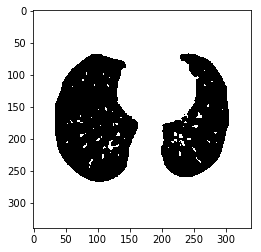

In [22]:
cleared = clear_border(binaries[i])
binary_1 = cleared

"""Plot"""
plt.imshow(clear_border(binaries[i]),cmap=cm.Greys)

C'est bien, mais il y avant de faire un remplissage, il faut garder toutes les parties connectées au mur de la paroi. Pour se faire, on va utiliser une opération de closing

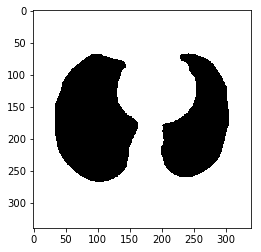

In [23]:
selem = disk(10)
binary_2 = binary_closing(binary_1, selem)

"""Plot"""
plt.imshow(binary_2,cmap=cm.Greys)

Ainsi, on a gardé tout ce qui était en contact avec les murs, quitte à avoir trop d'information

Pour finir, on utilise une opération de remplissage, qui va garder tout ce qui est à l'intérieur des poumons. Déjà implémanté en Python. Sur notre exemples, ça se voit pas car on a fait du closing, mais il est possible que ça soit utile

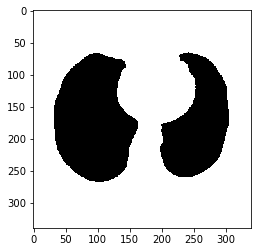

In [24]:
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel

edges = roberts(binary_2)
binary_3 = ndi.binary_fill_holes(edges)

"""Plot"""

plt.imshow(binary_3,cmap=cm.Greys)

Enfin, on utilise notre binary comme un masque pour récupérer l'information utile

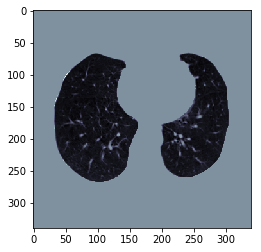

In [25]:
im = image[i]

get_high_vals = binary_3 == 0
im[get_high_vals] = 0

plt.imshow(im, cmap=plt.cm.bone) 

Le tout est accomplit par une fonction qui prend en entrée une image et en sortie ressort la "partie utile" de l'image



In [26]:
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel
from skimage.segmentation import clear_border
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing


def get_segmented_lungs(im):
    
    #Seuillage
    binary = im < -500
    
    #Gestion du bord
    binary = clear_border(binary)
    
    #Closing
    selem = disk(10)
    binary = binary_closing(binary, selem)
    
    #Filling
    edges = roberts(binary)
    binary= ndi.binary_fill_holes(edges)
    
    #Masque
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    
    return im



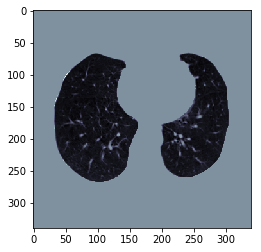

In [27]:
image = np.stack([get_segmented_lungs(s) for s in image])
plt.imshow(image[i], cmap=plt.cm.bone)

### Normer

On normalise, en recentrant sur une zone d'intérêt. En effet, au dessus de 400HU, on n'observe plus rien d'interessant

In [28]:
im_1 = get_segmented_lungs(image[i])

MIN_BOUND = -1024
MAX_BOUND = 400

print(MIN_BOUND)

-1024


In [29]:
def normalize(image):
    image = image.astype(np.float16)
    image = image / (MAX_BOUND - MIN_BOUND)
    return image


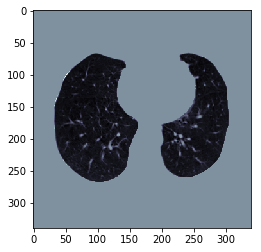

In [30]:
plt.imshow(normalize(im_1), cmap=plt.cm.bone) 

### Centrer

In [31]:
def center(image):
    #Trop compliqué de calculer sur toutes les données la moyenne, 0.25 est la moyenne empirique, ça sera suffisant
    im_mean = 0.25
    image = image-im_mean
    return image

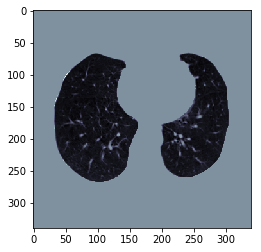

In [210]:
im = normalize(im_1)
im = center(im)
plt.imshow(im, cmap=plt.cm.bone) 

__WARNING__  Par la suite, on va ajouter beaucoup de zéros...et il y a de base beaucoup de zéros à cause de la segmentation. Décaler par un offset nos données va mettre beaucoup de valeurs à un nombre non nul et compliquer les calculs. Bref, par la suite, on ne fera pas de centerring

### Zero padding
Après ressampling (et même avant puisque le nombre de slices varie), la taille des images n'est pas identique, ce qui pose problème pour feed notre réseau
On va donc appliquer un zero-padding classique en première approche

In [32]:
def zero_padding(im,max_z=400,max_x=450,max_y=450):
    #Les dimensions sont prises empiriquement, au vu des shape montrees precedemment 
    borders = (max_z,max_x,max_y)
    fill_total = [[0,0],[0,0],[0,0]]
    for i in range(3):
        current_shape = im.shape[i]
        if (current_shape < borders[i]):
            fill = borders[i] - current_shape
            fill_left = fill/2
            fill_right = fill/2 + fill % 2
            fill_total[i] = (fill_left,fill_right)
    im = np.pad(im,((fill_total[0][0],fill_total[0][1]),(fill_total[1][0],fill_total[1][1]),(fill_total[2][0],fill_total[2][1])),'constant',constant_values=0)
    #Si jamais notre image depasse les dimensions du zero padding, on va la cut de base
    im = im[0:max_z,0:max_x,0:max_y]
    return im

Ici s'arrête la partie pre-processing, on a de quoi feed notre Network


Retenons les fonctions __PixelData_to_HU__, __get_segmented_lungs__, __normalize__, __center__, __load_scan__,__resample__ qui seront utilisées sans être réintroduites